<h1>Minimum Distance Analysis for Field Emission from a Ring-Shaped Emitter

<h3>Import

In [3]:
# Math
import numpy as np
import math as m
# Data
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h4>Functions

In [4]:
def ave_min(data):
    '''Find the average minimum angle from each point to its nearest neighbour'''
    # Calculate the distance between each point
    min_dist = 0
    for i in range(len(data)):
        min_dist += data.iloc[i]['min_dist']
    ave_min_dist = min_dist/len(data)
    return ave_min_dist

<h4>Fetch data

In [5]:
simulations = {
    10000: {'time_start': 500, 'time_end': 2000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'field': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    11000: {'time_start': 400, 'time_end': 2000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'field': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    12000: {'time_start': 300, 'time_end': 2000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'field': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    14000: {'time_start': 300, 'time_end': 2000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'field': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    15000: {'time_start': 300, 'time_end': 1000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'field': 0, 'distance': 1000e-9, 'ave_min_dist': 0}
}
filebase = f'/out/elec-'
dt_abs_type = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64), ('min_dist', np.float64)])

for voltage,simulation in simulations.items():
    simulations[voltage]['field'] = voltage/simulation['distance']

    time_steps = np.arange(simulation['time_start'], simulation['time_end']+1, simulation['time_step'], dtype=int)
    for time_step in time_steps:
        filename = f'./V{voltage}{filebase}{time_step}.bin'
        data_mem_abs = np.memmap(filename, dtype=dt_abs_type, mode='r', order='F')

        data = pd.DataFrame.from_records(data=data_mem_abs, columns=data_mem_abs.dtype.names)
        slice_data = data[(data['z'] >= simulation['d_min']) & (data['z'] <= simulation['d_max'])]

        try:
            simulations[voltage]['ave_min_dist'] += ave_min(slice_data)
        except ZeroDivisionError:
            print(time_step)

    simulations[voltage]['ave_min_dist'] /= len(time_steps)


<h4>Minimum distance as a function of field

Slope: -2.95


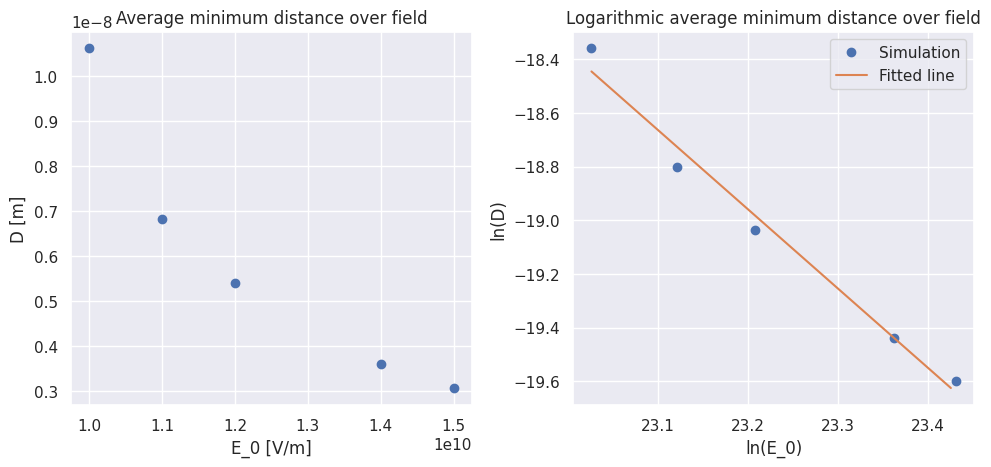

In [6]:
fig = plt.figure(figsize=(10,5))

E = []
D = []
for voltage,simulation in simulations.items():
    E.append(simulation['field'])
    D.append(simulation['ave_min_dist'])

ax1 = fig.add_subplot(121)
ax1.plot(E, D,'o', label='Simulation')
ax1.set_xlabel('E_0 [V/m]')
ax1.set_ylabel('D [m]')
ax1.set_title('Average minimum distance over field')

ax2 = fig.add_subplot(122)
log_E = [np.log(e) for e in E]
log_D = [np.log(d) for d in D]
slope, intercept = np.polyfit(log_E, log_D, 1)
log_E_fit = np.arange(min(log_E), max(log_E), 0.1)
log_D_fit = slope*log_E_fit + intercept
print(f'Slope: {slope:.2f}')

ax2.plot(log_E, log_D, 'o', label='Simulation')
ax2.plot(log_E_fit, log_D_fit, label=f'Fitted line')
ax2.set_xlabel('ln(E_0)')
ax2.set_ylabel('ln(D)')
ax2.legend()
ax2.set_title('Logarithmic average minimum distance over field')

plt.tight_layout()
plt.show()

<h3>Sample plot

In [7]:
# Input parameters
low = 0 # low z value of slice in nm (0 for ignore)
high = 2 # high z value of slice in nm(0 for ignore)
time_step = 500 # time step of sample

# Memory map file
filename = f'./out/elec-{time_step}.bin'
dt_abs_type = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64), ('dist', np.float64)])
data_mem_abs = np.memmap(filename, dtype=dt_abs_type, mode='r', order='F')
    
# Read the data into dataframe 
sample_data = pd.DataFrame.from_records(data=data_mem_abs, columns=data_mem_abs.dtype.names)
if high == 0: high = m.ceil(sample_data['z'].max()*1e9)
if low == 0: low = m.floor(sample_data['z'].min()*1e9)
slice_data = sample_data[(sample_data['z'] > low*1.0e-9) & (sample_data['z'] < high*1.0e-9)]

avg_min_dist = ave_min(slice_data)
print(f'Average minimum distance: {avg_min_dist} nm')

# 3D plot of sample data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(slice_data['x']*1e9, slice_data['y']*1e9, slice_data['z']*1e9, s=5)
ax.set_xlabel('x [nm]')
ax.set_ylabel('y [nm]')
ax.set_zlabel('z [nm]')
ax.set_title(f'Slice z =[{low},{high}] nm at time step {time_step}.')
plt.show()

# 2D plot of sample data with density plot
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(121)
ax1.scatter(slice_data['x']*1e9, slice_data['z']*1e9, s=1)
ax1.set_xlabel('x [nm]')
ax1.set_ylabel('z [nm]')
ax1.set_title(f'Slice z =[{low},{high}] nm at time step {time_step}.')

ax2 = fig.add_subplot(122)
ax2.hist(slice_data['z']*1e9, bins=max(high-low,100), orientation='horizontal')
ax2.set_ylabel('z [nm]')
ax2.set_xlabel('Count')
ax2.set_title(f'Slice z =[{low},{high}] nm at time step {time_step}.')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './out/elec-500.bin'

<h3>Ring plot<h3>

In [ ]:
def ave_min(data):
    '''Find the average minimum angle from each point to its nearest neighbour'''
    # Calculate the distance between each point
    min_dist = 0
    for i in range(len(data)):
        min_dist += data.iloc[i]['dist']
    ave_min_dist = min_dist/len(data)*1e9
    return ave_min_dist

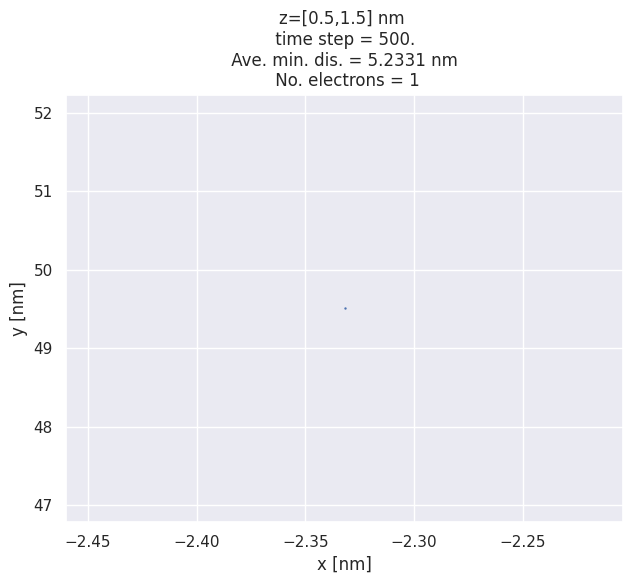

In [ ]:
# tot_min=ave_min(sample_data)
# print(tot_min)

ring_levels = [1] # height of the ring in nm
ring_data =[None]*len(ring_levels)
dev = [0.5]*len(ring_levels) # deviation from the ring height in nm

fig = plt.figure(figsize=(18, 6))
for i, level in enumerate(ring_levels):
    dev_nm = dev[i]
    ring_data[i] = sample_data[(sample_data['z'] >= (level-dev_nm)*1e-9)&(sample_data['z'] <= (level+dev_nm)*1e-9)]
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(ring_data[i]['x']*1e9, ring_data[i]['y']*1e9, s=0.5)
    ax.set_xlabel('x [nm]')
    ax.set_ylabel('y [nm]')
    min_dis = ave_min(ring_data[i])
    ax.set_title(f'z=[{level-dev_nm},{level+dev_nm}] nm \n time step = {time_step}. \n Ave. min. dis. = {round(min_dis,4)} nm \n No. electrons = {len(ring_data[i])}')
plt.tight_layout()

<h3>Anode and cathode plot<h3>

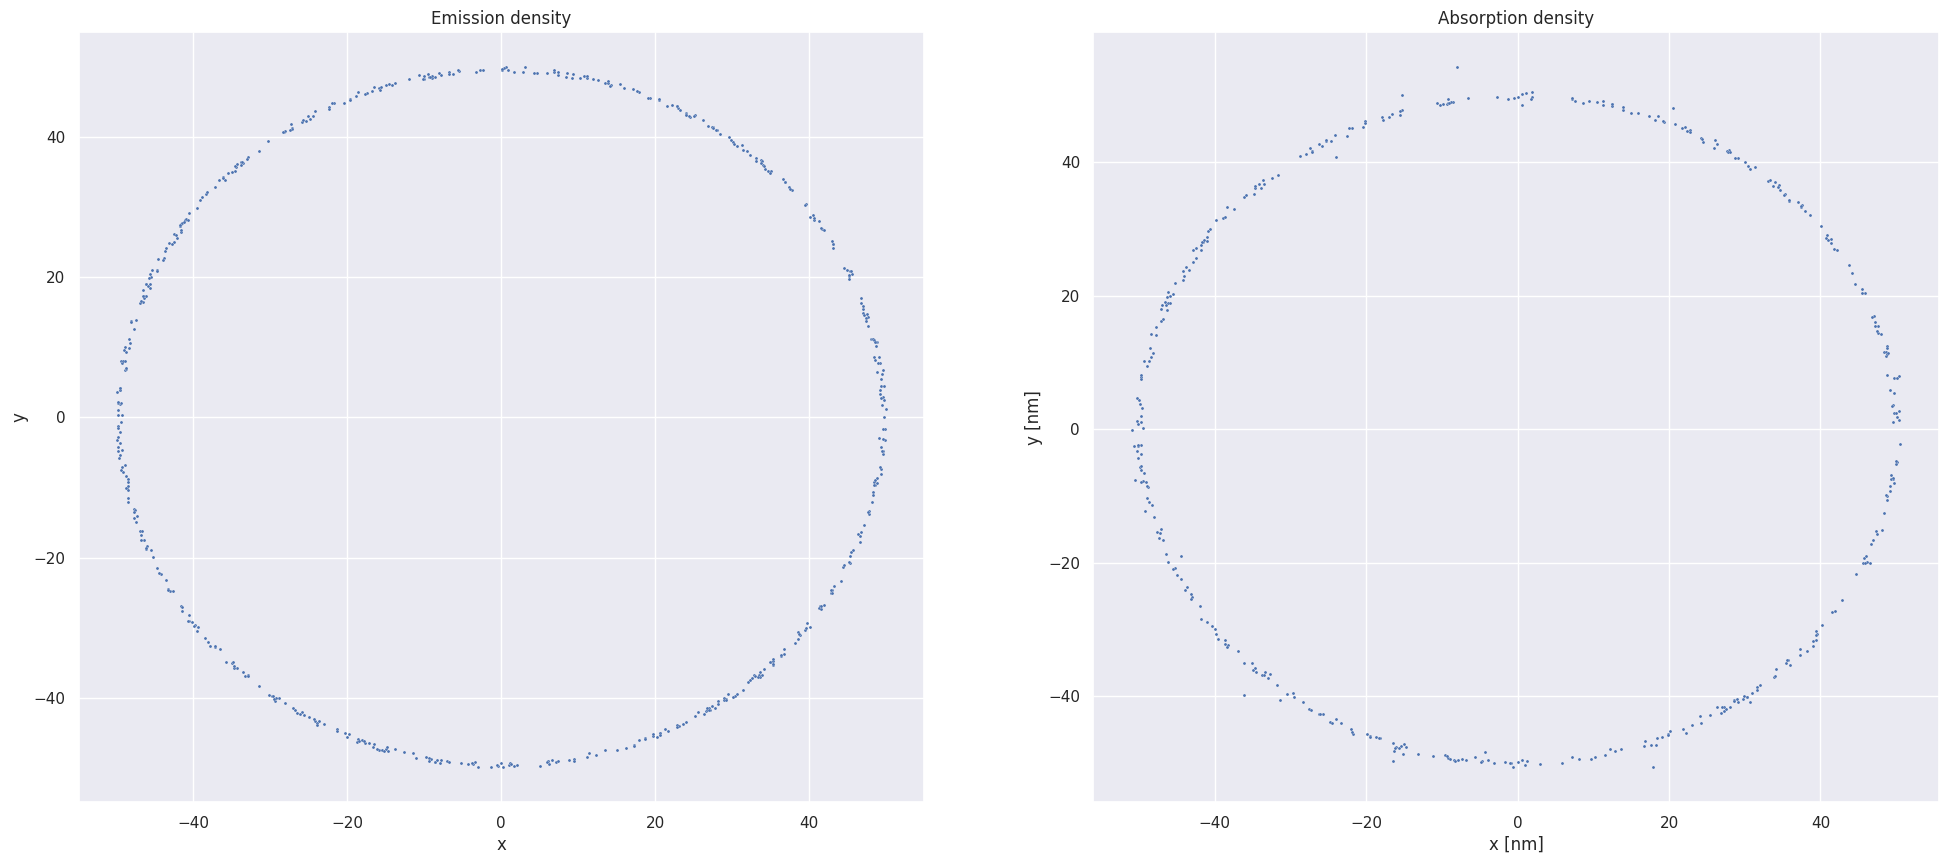

In [ ]:

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import math

import seaborn as sns
sns.set_theme()

import os.path as path

# Emission density
fig2, axes = plt.subplots(1, 2, figsize=(24, 10))


filename = './out/density_emit_elec.bin'

# Binary file layout
# float64 (double precision numbers)
# int32 (32bit integers)
dt_emit_type = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64), ('emit', np.int64), ('nr', np.int64)])

# Memory map the file
# mode=r (Read only)
# order=F (Fortran style array)
data_mem_emit = np.memmap(filename, dtype=dt_emit_type, mode='r', order='F')
    
# Read the data into dataframe
df_emit = pd.DataFrame.from_records(data=data_mem_emit, columns=data_mem_emit.dtype.names)
    
# Add first joint plot (top right)
sns.scatterplot(data=df_emit, x="x", y="y", s=5, ax=axes[0])
axes[0].set_title('Emission density')

# Absorption density
filename = './out/density_absorb_top.bin'

# Binary file layout
# float64 (double precision numbers)
# int32 (32bit integers)
dt_abs_type = np.dtype([('x [nm]', np.float64), ('y [nm]', np.float64), ('vx', np.float64), ('vy', np.float64), ('vz', np.float64), ('emit', np.int64), ('sec', np.int64),  ('id', np.int64)])

# Memory map the file
# mode=r (Read only)
# order=F (Fortran style array)
data_mem_abs = np.memmap(filename, dtype=dt_abs_type, mode='r', order='F')
    
# Read the data into dataframe
sample_data = pd.DataFrame.from_records(data=data_mem_abs, columns=data_mem_abs.dtype.names)

# Add first joint plot (bottom right)
sns.scatterplot(data=sample_data, x="x [nm]", y="y [nm]", s=5, ax=axes[1])
axes[1].set_title('Absorption density')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.1)

# Show the plot
plt.show()